In [46]:
import pandas as pd
import math

# Поднять инвестиции в Salesify: описание кейса

Ваш продукт представлен в 3 тарифах:

- базовый (только аналитика)
- продвинутый (аналитика + автозаказ)
- премиальный (аналитика + автозаказ + управление рекламой)

Цены тарифов:

- базовый - 30 000 рублей в месяц
- продвинутый - 50 000 рублей в месяц
- премиальный - 100 000 рублей в месяц

Естественно, тарифы покупают неравномерно. За последний год структура продаж следующая (тарифы и цены не менялись):

- базовый - 55%
- продвинутый - 30%
- премиальный - 15%

## Теперь о монетизации - Sleepy работает по подписке: 990 рублей в месяц. Первые две недели бесплатно, затем клиент видит пейвол (от «pay wall» - как бы стена, которая тебя не пускает дальше, пока ты не оплатишь) и, если привязывает карту, продолжает пользоваться подпиской, а деньги списываются автоматически.

## Если говорить о привлечении, то это молодой венчурный стартап, поэтому привлечение одного пользователя (даже если он не заплатит) довольно дорогое - 500 рублей.

## Данных у вас немного - вам дан датасет всего из двух полей:


## user - номер пользователя в системе

## dt - дата его захода в приложение

## Данные устроены таким образом, что фиксируется только один заход пользователя за день - одинаковых пар "пользователь - дата" быть не может. 
## Кроме того, фиксируются только заходы пользователей на триальной версии и тех, кто прошел пейвол. 
## Если человек открыл приложение после 14 дня и не привязал карту - такой заход не фиксируется.

In [2]:
# n day retention


# WIN
users_sleepy = pd.read_csv(r'C:\Users\Incognitus\Downloads\entries.csv', sep=';') 
# MAC
# users_sleepy = pd.read_csv(r'/Users/vladislavlipkin/Downloads/entries.csv', sep=';') 

In [3]:
users_sleepy.head(5)

,user,dt,Unnamed: 2
0,0,12.11.2023,NaN
1,0,13.11.2023,NaN
2,0,14.11.2023,NaN
3,0,16.11.2023,NaN
4,0,17.11.2023,NaN


In [44]:
# --- подготовка данных ---
users_filter = users_sleepy.loc[:, ['user', 'dt']]
users_filter['dt'] = pd.to_datetime(users_filter['dt'], format='%d.%m.%Y')
users_filter['month_start'] = users_filter['dt'].dt.to_period('M').dt.to_timestamp()
users_filter['dt_reg'] = users_filter.groupby('user')['dt'].transform('min')
users_filter['diff'] = (users_filter['dt'] - users_filter['dt_reg']).dt.days
users_filter['week'] = round(users_filter['diff'] / 7, 0)
users_filter['month'] = round(users_filter['diff'] / 30, 0)


# --- считаем общее количество пользователей ---
all_users = users_filter['user'].nunique()

# --- retention по разным периодам ---
users_filter['N_DAY_retention']   = users_filter.groupby('diff')['user'].transform('nunique') / all_users * 100
users_filter['N_WEEK_retention']  = users_filter.groupby('week')['user'].transform('nunique') / all_users * 100
users_filter['N_MONTH_retention'] = users_filter.groupby('month')['user'].transform('nunique') / all_users * 100


# 🔹🔹🔹 Универсальная переменная для переключения периода 🔹🔹🔹
period = 'week'     # варианты: 'day', 'week', 'month'


# --- выбираем колонку и подписи в зависимости от периода ---
if period == 'day':
    idx_col = 'diff'
    period_name = 'Day'
elif period == 'week':
    idx_col = 'week'
    period_name = 'Week'
elif period == 'month':
    idx_col = 'month'
    period_name = 'Month'
else:
    raise ValueError("period must be 'day', 'week', or 'month'")


# --- создаем универсальный pivot ---
pivot = (
    users_filter
    .groupby(idx_col, as_index=False)['user']
    .nunique()
    .rename(columns={'user': 'unique_users'})
)

pivot['retention'] = pivot['unique_users'] / all_users * 100
pivot['period'] = period_name  # добавляем столбец для понятного вывода

# --- создаем полный диапазон индексов ---
full_range = pd.DataFrame({idx_col: range(int(pivot[idx_col].min()), int(pivot[idx_col].max()) + 1)})
pivot_full = full_range.merge(pivot, on=idx_col, how='left')

# --- вывод ---
print(f"Retention by {period_name}")
display(pivot_full.head(30))
print(f'retention: {pivot_full['retention'].sum() / 100}')

Retention by Week


,week,unique_users,retention,period
0,0,2000,100.00,Week
1,1,1812,90.60,Week
2,2,1660,83.00,Week
3,3,1476,73.80,Week
4,4,1395,69.75,Week
5,5,1344,67.20,Week
6,6,1339,66.95,Week
7,7,1264,63.20,Week
8,8,1205,60.25,Week
9,9,1143,57.15,Week


retention: 14.5975


In [37]:
users_filter.groupby('diff')['user'].nunique().query('14 < diff < 15')
# pivot_full.query('13 < diff < 16')['unique_users'].nunique

AttributeError: 'Series' object has no attribute 'query'

In [5]:
# 25 minutes
users_filter.sort_values(by='dt', ascending=True).head(20)

,user,dt,month_start,dt_reg,diff,week,month,N_DAY_retention,N_WEEK_retention,N_MONTH_retention
24607,940,2023-02-18,2023-02-01,2023-02-18,0,0.0,0.0,100.00,100.0,100.0
32045,1224,2023-02-18,2023-02-01,2023-02-18,0,0.0,0.0,100.00,100.0,100.0
37567,1438,2023-02-18,2023-02-01,2023-02-18,0,0.0,0.0,100.00,100.0,100.0
51147,1960,2023-02-18,2023-02-01,2023-02-18,0,0.0,0.0,100.00,100.0,100.0
19446,740,2023-02-19,2023-02-01,2023-02-19,0,0.0,0.0,100.00,100.0,100.0
14570,553,2023-02-19,2023-02-01,2023-02-19,0,0.0,0.0,100.00,100.0,100.0
50719,1941,2023-02-19,2023-02-01,2023-02-19,0,0.0,0.0,100.00,100.0,100.0
17388,659,2023-02-19,2023-02-01,2023-02-19,0,0.0,0.0,100.00,100.0,100.0
51148,1960,2023-02-19,2023-02-01,2023-02-18,1,0.0,0.0,51.95,100.0,100.0
32046,1224,2023-02-19,2023-02-01,2023-02-18,1,0.0,0.0,51.95,100.0,100.0


In [6]:
# среднее MAU за весь период
user_in_month = users_filter.groupby('month_start')['user'].nunique().reset_index(name='unique_users')
average_mau = user_in_month['unique_users'].mean()
average_mau

458.9655172413793

In [7]:
# среднее DAU за весь период

# --- считаем количество уникальных пользователей по каждой дате ---
user_in_day = (
    users_filter.groupby('dt')['user']
    .nunique()
    .reset_index(name='unique_users')
)
# --- создаем полный список дат ---

full_dates = pd.DataFrame({
    'dt': pd.date_range(users_filter['dt'].min(), users_filter['dt'].max())
})
# --- добавляем пропущенные даты ---
user_in_day_full = (
    full_dates
    .merge(user_in_day, on='dt', how='left')
    .fillna({'unique_users': 0})  # ставим 0, если в этот день нет пользователей
)
# --- считаем среднее DAU ---
average_dau = user_in_day_full['unique_users'].mean()
average_dau

60.984848484848484

In [8]:
# Sticky_factor
print(f'average_DAU: {round(average_dau, 1)}')
print(f'average_MAU: {round(average_mau, 1)}')
print()
print(f'Sticky_factor: {average_dau / average_mau * 100}')

average_DAU: 61.0
average_MAU: 459.0

Sticky_factor: 13.287457596247979


In [9]:
# Во сколько раз LT методом усреднения разницы между 
# максимальным и минимальным заходом каждого пользователя 
# больше LT методом классического n-day retention (считаем в днях). 26
# Ответ округлите в меньшую сторону.

In [10]:
n_day_retention = pivot_full['retention'].sum() / 100
print(f'retention: {n_day_retention}')

retention: 26.162500000000005


In [11]:
# --- рассчитываем LT (Lifetime) ---
lt_per_user = (
    users_filter.groupby('user')['dt']
    .agg(['min', 'max'])              # находим первую и последнюю дату активности
    .assign(lifetime=lambda x: (x['max'] - x['min']).dt.days)  # разница в днях
)

# среднее "время жизни" пользователя
LT = lt_per_user['lifetime'].mean()

print(f"Средний LT (lifetime): {LT:.2f} дней")

Средний LT (lifetime): 223.20 дней


In [12]:
LT / n_day_retention

8.531313903487815

In [13]:
# Посчитайте MAU каждого месяца на основании календарных месяцев. 
# В какой месяц была самая высокая пользовательская активность? 
# Ответ дайте в формате YYYY-MM, например, 2024-07.

In [14]:
# --- считаем уникальных пользователей по месяцам ---
pivot = (
    users_filter
    .groupby('month_start', as_index=False)['user']
    .nunique()
    .rename(columns={'user': 'unique_users'})
)

# --- считаем retention ---
pivot['retention'] = pivot['unique_users'] / all_users * 100
pivot['period'] = 'Month'  # или period_name, если он у тебя есть выше

# --- добавляем колонку YYYY-MM ---
pivot['year_month'] = pivot['month_start'].dt.strftime('%Y-%m')

# --- создаем полный диапазон месяцев ---
full_range = pd.DataFrame({
    'month_start': pd.date_range(
        users_filter['month_start'].min(),
        users_filter['month_start'].max(),
        freq='MS'  # начало каждого месяца
    )
})

# --- объединяем с pivot, чтобы добавить пропущенные месяцы ---
pivot_full = full_range.merge(pivot, on='month_start', how='left')

# --- финальный вывод ---
pivot_full.sort_values(by='unique_users', ascending=False).head(20)

,month_start,unique_users,retention,period,year_month
15,2024-05-01,841,42.05,Month,2024-05
14,2024-04-01,826,41.30,Month,2024-04
11,2024-01-01,812,40.60,Month,2024-01
13,2024-03-01,802,40.10,Month,2024-03
16,2024-06-01,795,39.75,Month,2024-06
10,2023-12-01,789,39.45,Month,2023-12
12,2024-02-01,764,38.20,Month,2024-02
9,2023-11-01,739,36.95,Month,2023-11
8,2023-10-01,729,36.45,Month,2023-10
17,2024-07-01,708,35.40,Month,2024-07


In [15]:
users_filter.head(10)

,user,dt,month_start,dt_reg,diff,week,month,N_DAY_retention,N_WEEK_retention,N_MONTH_retention
0,0,2023-11-12,2023-11-01,2023-11-12,0,0.0,0.0,100.00,100.0,100.0
1,0,2023-11-13,2023-11-01,2023-11-12,1,0.0,0.0,51.95,100.0,100.0
2,0,2023-11-14,2023-11-01,2023-11-12,2,0.0,0.0,52.60,100.0,100.0
3,0,2023-11-16,2023-11-01,2023-11-12,4,1.0,0.0,51.20,90.6,100.0
4,0,2023-11-17,2023-11-01,2023-11-12,5,1.0,0.0,48.40,90.6,100.0
5,0,2023-11-18,2023-11-01,2023-11-12,6,1.0,0.0,49.20,90.6,100.0
6,0,2023-11-19,2023-11-01,2023-11-12,7,1.0,0.0,46.35,90.6,100.0
7,0,2023-11-21,2023-11-01,2023-11-12,9,1.0,0.0,47.90,90.6,100.0
8,0,2023-11-22,2023-11-01,2023-11-12,10,1.0,0.0,47.05,90.6,100.0
9,0,2023-11-23,2023-11-01,2023-11-12,11,2.0,0.0,44.85,83.0,100.0


KeyError: 'diff'

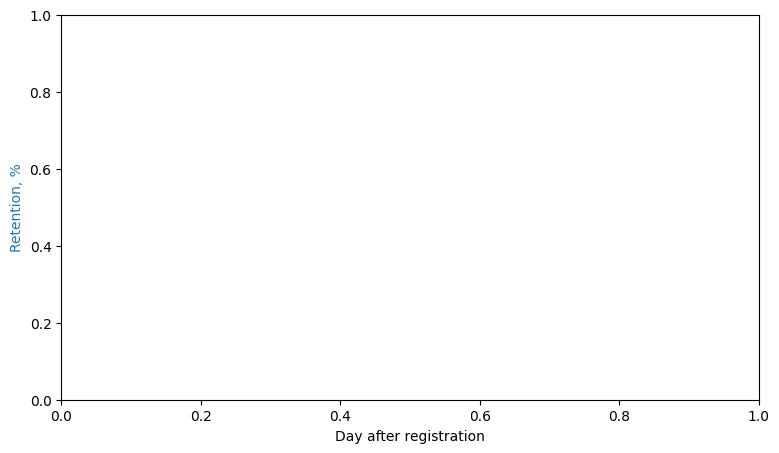

In [16]:

fig, ax1 = plt.subplots(figsize=(9, 5))

# --- Первая ось: Retention ---
color = 'tab:blue'
ax1.set_xlabel(f'{period_name} after registration')
ax1.set_ylabel('Retention, %', color=color)
ax1.plot(pivot_full[idx_col], pivot_full['retention'], color=color, marker='o', linewidth=2, label='Retention %')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='major', axis='both', linestyle='--', alpha=0.5)

# --- Вторая ось: количество уникальных пользователей ---
ax2 = ax1.twinx()  # создаём вторую ось Y
color = 'tab:orange'
ax2.set_ylabel('Unique users', color=color)
ax2.bar(pivot_full[idx_col], pivot_full['unique_users'], color=color, alpha=0.3, label='Unique users')
ax2.tick_params(axis='y', labelcolor=color)

# --- Заголовок и оформление ---
plt.title(f'Retention and Unique Users by {period_name}')
fig.tight_layout()
plt.show()

In [ ]:
6 * 990

In [ ]:
users_filter

In [ ]:
# users_filter['month'] = round(users_filter['diff'] / 30, 0)
# users_filter['week'] = round(users_filter['diff'] / 7, 0)
users_filter

In [ ]:
print(f'count of month: {users_filter['month'].sum() / 100}')
print(f'count of week: {users_filter['week'].sum() / 100}')

In [42]:
# count users paying
cpu = users_filter.query('diff >= 14')['user'].nunique()
print(f'количество людей купивших подписку : {cpu}')
print()
price_all_users = all_users * 500
net_profit = cpu * 990 - price_all_users
print(f'стоимость привлечения за всех пользователей {price_all_users}')
print()
print(f'выручка за все проданные подписки: {cpu * 990}')
print()
print(f'чистая прибыль с учетом затратов: {net_profit}')
print(f'CPU: {users_filter.query(' 17 > diff >= 14')['user'].nunique()}')

количество людей купивших подписку : 1981

стоимость привлечения за всех пользователей 1000000

выручка за все проданные подписки: 1961190

чистая прибыль с учетом затратов: 961190
CPU: 1076
